In [37]:
# Module import
import torch
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Utilize GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

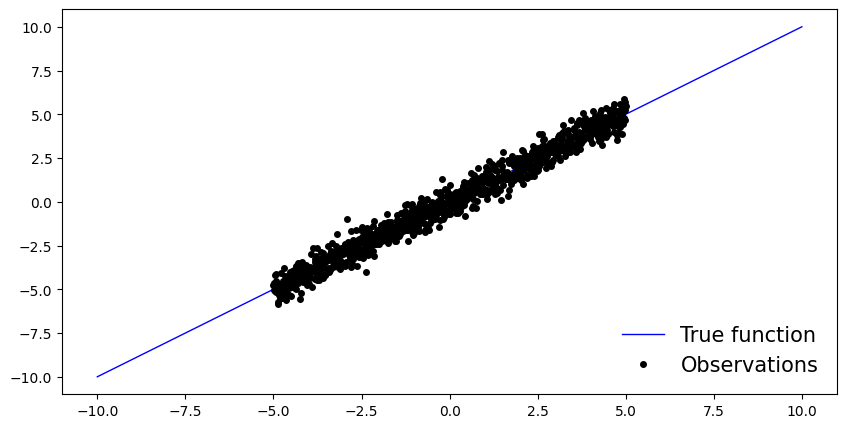

In [39]:
# Generate dataset about x axis value
array1 = np.linspace(-5, -0, num=501)
array2 = np.linspace(0, 5, num=501)
x = np.hstack((array1, array2))

# Generate dataset about y axis value
Gaussian_noise = np.random.normal(0, .5, x.shape) # gaussian noise with sigma = 0.5
y = x + Gaussian_noise

# Unsqueeze dataset
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()
# x_train = torch.unsqueeze(x, dim=1)
# y_train = torch.unsqueeze(y, dim=1)


x_true = np.linspace(-10, 10, 1000)
y_true = x_true

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=1, label="True function")
ax.plot(x, y, 'ko', markersize=4, label="Observations")
ax.legend(loc=4, fontsize=15, frameon=False)

In [40]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

In [41]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class BayesianNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [42]:
model = BayesianNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [01:48,  1.09s/it, step size=7.46e-03, acc. prob=0.494]


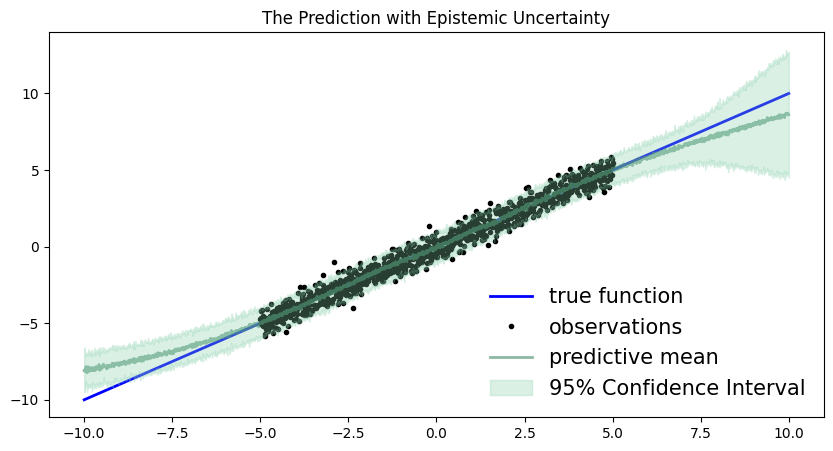

In [44]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(-10, 10, 2000)
preds = predictive(x_test)

def plot_predictions(preds,range):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_title('The Prediction with Epistemic Uncertainty')
    ax.plot(x_true, y_true, 'b-', linewidth=2, label="true function")
    ax.plot(x, y, 'ko', markersize=3, label="observations")
    ax.plot(x_test, y_pred, '-', linewidth=2, color="#408765", alpha = 0.6, label="predictive mean")
    ax.fill_between(x_test, y_pred - range * y_std, y_pred + range * y_std, alpha=0.3, color='#86cfac', zorder=5, label="95% Confidence Interval")

    plt.legend(loc=4, fontsize=15, frameon=False)

plot_predictions(preds,range=1.96)
plt.savefig('file/result_-5_5_sigma0.5.png')

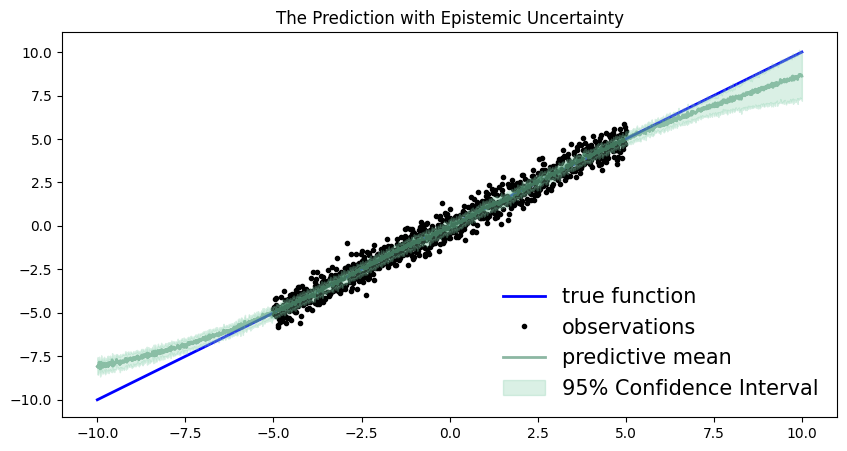

In [45]:
plot_predictions(preds,range=0.6745)

# Reference
[Bayesian Neural Network - Pyro](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html)